In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [51]:
# Ajuster les options d'affichage
pd.set_option('display.max_columns', None)  # Aucune limite sur le nombre de colonnes affichées
pd.set_option('display.max_colwidth', None)  # Aucune limite sur la largeur du contenu de la colonne

In [52]:
# Correctly specifying your file path
path_audible_5s_train = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/train_audible_recording_chunks.csv"
path_audible_5s_test = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/test_audible_recording_chunks.csv"
path_audible_5s_val = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/val_audible_recording_chunks.csv"

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_audible_5s_train)
df_test = pd.read_csv(path_audible_5s_test)
df_val = pd.read_csv(path_audible_5s_val)

In [53]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

def clean_data(df):
    y = df['label']
    y_category = df['label_category']
    y_kingdom = df['label_kingdom']
    y_class = df['label_class']
    y_order = df['label_order']
    y_family = df['label_family']
    y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    y_encoded = label_encoder.transform(y)

    df['duree'] = df['duree_min'] * 60 + df['duree_sec']
    df = df[['min_frequency', 'max_frequency', 'avg_frequency', 'duree']]
    df['min_frequency'] = df['min_frequency'].astype(int)
    df['max_frequency'] = df['max_frequency'].astype(int)

    # Gestion des valeurs manquantes
    #df.fillna(df.mean(), inplace=True)
    df = df.dropna()
    
    # Gestion des variables catégorielles
    df = pd.get_dummies(df)

    X = df

    return X, y_encoded

X_train, y_train = clean_data(df_train)
X_test, y_test = clean_data(df_test)
X_val, y_val = clean_data(df_val)

C:\Users\cdelm\AppData\Local\Temp\ipykernel_38892\771953224.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['min_frequency'] = df['min_frequency'].astype(int)
C:\Users\cdelm\AppData\Local\Temp\ipykernel_38892\771953224.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['max_frequency'] = df['max_frequency'].astype(int)
C:\Users\cdelm\AppData\Local\Temp\ipykernel_38892\771953224.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [54]:
X_train

,min_frequency,max_frequency,avg_frequency,duree
0,0,375,187.613067,17
1,3248,4453,602.868652,17
2,3248,4453,602.868652,17
3,0,375,187.613067,17
4,3248,4453,602.868652,17
...,...,...,...,...
10784,5007,16160,5576.321777,185
10785,4750,16553,5901.409424,185
10786,5416,17367,5975.480225,185
10787,5007,15776,5384.266602,185


In [55]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [56]:
num_classes = max(y_train) + 1

params = {
    'num_leaves':300,
    'min_data_in_leaf':30,
    'max_depth':20,
    'learning_rate':0.03,
    'min_child_samples':20,
    "boosting":"gbdt",
    "feature_fraction":0.9,
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
}

In [57]:
# Évaluation sur l'ensemble de validation
num_round = 100
model = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=num_round)])

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 10789, number of used features: 4
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Start training from score -5.436135
[LightGBM] [Info] Start training from score -4.450000
[LightGBM] [Info] Start training from score -5.415081
[LightGBM] [Info] Start training from score -4.104499
[LightGBM] [Info] Start training from score -3.475141
[LightGBM] [Info] Start training from score -5.457641
[LightGBM] [Info] Start

In [58]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
lgbm_predictions = [np.argmax(pred) for pred in y_pred] 

In [59]:
from sklearn.metrics import accuracy_score, classification_report

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_test, lgbm_predictions))
print(classification_report(y_test, lgbm_predictions))

Évaluation LightGBM :
Accuracy sur l'ensemble de validation: 0.772984441301273
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.60      0.90      0.72        10
           2       0.00      0.00      0.00         4
           3       0.95      0.86      0.90        22
           4       0.84      0.84      0.84        38
           5       1.00      1.00      1.00         8
           6       0.77      1.00      0.87        10
           7       0.50      0.42      0.45        12
           8       0.56      0.50      0.53        10
           9       1.00      1.00      1.00         5
          10       0.91      0.87      0.89        23
          11       1.00      1.00      1.00         7
          12       0.92      0.44      0.59        25
          13       0.22      0.40      0.29         5
          14       0.50      0.27      0.35        15
          15       0.76      0.95      0.84        20
  

In [60]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lgbm_predictions)
y_test_inversed = label_encoder.inverse_transform(y_test)

In [61]:
unique_labels = np.unique(y_test_inversed)

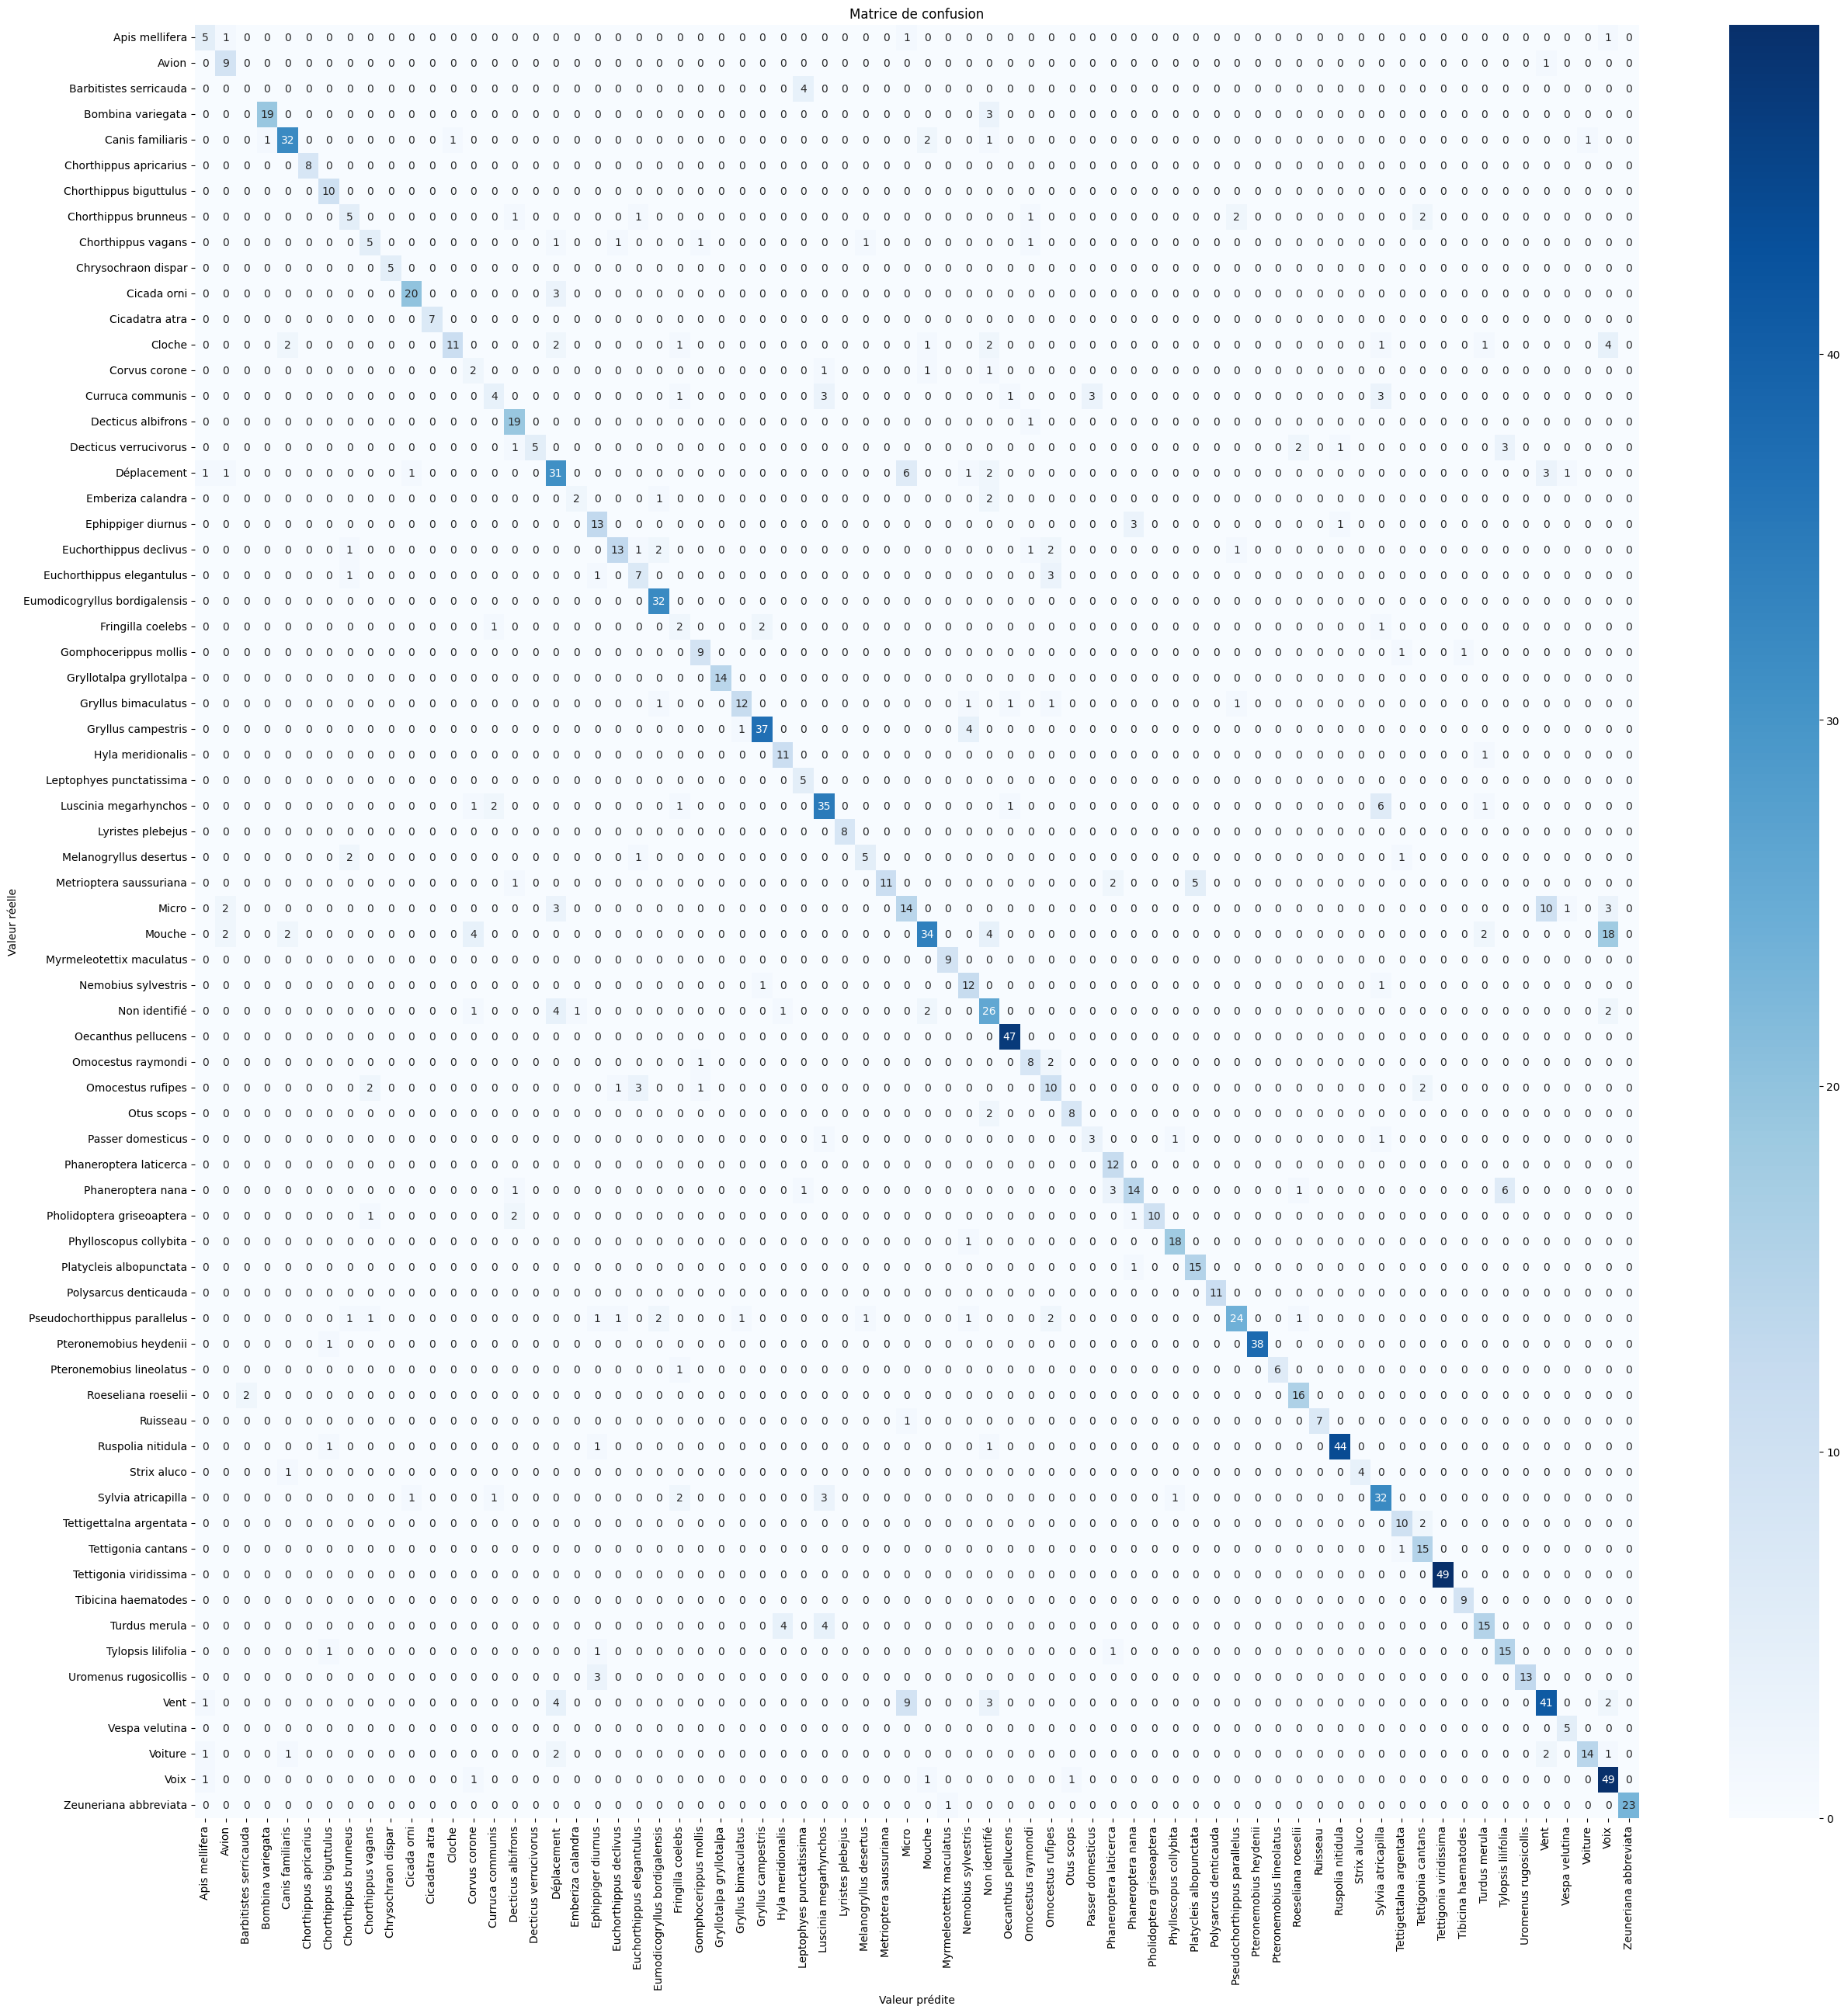

In [62]:
plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()